In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning

In [49]:
data = pd.read_csv("datasets_hi4/train-data.csv",sep=";")

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173346 entries, 0 to 3173345
Data columns (total 19 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   index                           int64 
 1   id_product                      int64 
 2   Region                          object
 3   Country                         object
 4   Site                            object
 5   Operations                      object
 6   Zone                            object
 7   Cluster                         object
 8   Reference proxy                 object
 9   Product  Line proxy             object
 10  Division proxy                  object
 11  Customer Persona proxy          object
 12  Strategic Product Family proxy  object
 13  Product Life cycel status       object
 14  Date                            object
 15  Month 1                         object
 16  Month 2                         object
 17  Month 3                         object
 18  Mo

All features except the two first one are categorical or named entities. We have to transform all of these columns type from objects to numerics. 

In [51]:
data.describe()

,index,id_product
count,3.173346e+06,3.173346e+06
mean,1.101597e+06,1.223989e+05
std,6.362905e+05,7.068357e+04
min,0.000000e+00,0.000000e+00
25%,5.506670e+05,6.115800e+04
50%,1.101594e+06,1.223590e+05
75%,1.652761e+06,1.836168e+05
max,2.203712e+06,2.448560e+05


In [52]:
data.nunique()

index                             1762970
id_product                         244857
Region                                  4
Country                                31
Site                                   88
Operations                              5
Zone                                   12
Cluster                                18
Reference proxy                     22406
Product  Line proxy                     6
Division proxy                          3
Customer Persona proxy                 72
Strategic Product Family proxy         19
Product Life cycel status               3
Date                                    9
Month 1                              4619
Month 2                              4471
Month 3                              5040
Month 4                              4360
dtype: int64

In [53]:
data.isna().sum()

index                                   0
id_product                              0
Region                                  0
Country                                 0
Site                                    0
Operations                              0
Zone                                    0
Cluster                                 0
Reference proxy                         0
Product  Line proxy                     0
Division proxy                          0
Customer Persona proxy                  0
Strategic Product Family proxy          0
Product Life cycel status         2742544
Date                                    0
Month 1                            352330
Month 2                                 0
Month 3                                 0
Month 4                                 0
dtype: int64

We want to check if the index feature is a relevant predictor. 

In [54]:
data.groupby("index").count().iloc[:,0].value_counts()

id_product
2    1410376
1     352594
Name: count, dtype: int64

Among all the index, 1410376 are duplicated(present two times) and 352594 are uniques, why ? Should not an index be unique ? 

Let check an index which is duplicated and try to understand

In [55]:
index_grouped = data.groupby("index").count()
index_grouped.head(5)

,id_product,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4
index,,,,,,,,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Index 0 is duplicated, let's use it.

In [56]:
data[data["index"]==0]

,index,id_product,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4
946355,0,0,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,Division-1,Customer Segmentation-1,Strategic Product Family-1,NaN,sep-dec 2020,0,0,0,0
2061569,0,0,EAJP,AU,AU_DC_Sydney,International Operations,Pacific,Australia,reference-1,Product Line-1,Division-1,Customer Segmentation-1,Strategic Product Family-1,NaN,sep-dec 2020,0,0,0,0


The two rows are identics. Thus we will drop the duplicates rows to avoid our model to learn the same behaviour several times. Moreover, we can also remove the index column which is now different for each row. We also want to remove the id_product. Indeed, it is an information specific to each product thus new id_product will be be created for each new product. And imagine that your model learn from it, then when a new product will come, your model will completly outperform.

In [58]:
data = data.drop_duplicates()
data.reset_index(drop=True,inplace=True)
data.drop(columns=["index","id_product"],inplace=True)

In [59]:
data["Product Life cycel status"].value_counts()

Product Life cycel status
EOL         174212
NPI          62090
RaMPDOWN      2995
Name: count, dtype: int64

NaN for Product Life cycle status are not really missings values but encoding for : Active Lifecycle. Thus, we should change NaN by AL to avoid NaN missinterpretation.

In [60]:
data["Product Life cycel status"].fillna("Active",inplace=True)
data.head(5)

,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4
0,EUROPE,DE,NL_DC_Venray,Europe Operations,DACH,Germany,reference-13523,Product Line-4,Division-3,Customer Segmentation-3,Strategic Product Family-12,Active,may-aug 2021,0,0,0,0
1,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,China,reference-12778,Product Line-4,Division-3,Customer Segmentation-14,Strategic Product Family-9,Active,jan-apr 2021,0,1,0,0
2,EUROPE,GB,NL_DC_HLD,Europe Operations,UK and Ireland,United Kingdom,reference-3513,Product Line-3,Division-2,Customer Segmentation-23,Strategic Product Family-7,Active,jan-apr 2021,0,2,0,0
3,EAJP,AU,AU_DC_Perth,International Operations,Pacific,Australia,reference-672,Product Line-1,Division-1,Customer Segmentation-11,Strategic Product Family-3,Active,jan-apr 2023,0,0,0,0
4,EUROPE,ES,NL_DC_HLD,Europe Operations,Iberia,Spain,reference-3496,Product Line-3,Division-2,Customer Segmentation-14,Strategic Product Family-7,Active,jan-apr 2021,0,0,0,0


If we look at Country and Cluster columns, we can wonder that some information are redondants because Country values seem to be the acronym of Cluster's values.

In [61]:
data[["Country","Cluster"]].value_counts()

Country  Cluster              
US       USA                      329173
AU       Australia                263395
FR       France                   168295
CN       China                    161724
DE       Germany                  127705
IT       Italy                    106304
GB       United Kingdom            92859
ES       Spain                     84858
NL       Netherlands               81447
PL       Middle Eastern Europe     72415
BE       Belgium                   71995
DK       Denmark                   51241
SE       Sweden                    43332
HK       Hong Kong & Macao         26972
SG       South East Asia           11757
Id       South East Asia            9809
TH       South East Asia            9693
VN       South East Asia            8552
MY       South East Asia            8414
PH       South East Asia            7654
JP       North East Asia            7232
NZ       New Zealand                5632
KR       North East Asia            4850
TW       North East Asia  

It is not completly the case, we observe that the major part of pairs share the same information. But cluster is lower level that country. Indeed, some countries are grouped into the same category, such as SG, Id, Th, VN in South East Asia. 

We may want to remove country from the columns if our future model is overfitting because a lot of same information are shared between these two columns and we want to keep the lower level in order to avoid overfitting. Otherwise, we will keep country if our model is underfitting.

In [62]:
data["Date"].value_counts()

Date
sep-dec 2020    196272
may-aug 2021    196083
sep-dec 2022    195955
jan-apr 2023    195916
may-jul 2023    195865
sep-dec 2021    195776
jan-apr 2022    195738
may-aug 2022    195706
jan-apr 2021    195659
Name: count, dtype: int64

Year information is in the Date feature value, then we gonna extract from it and make a new column reprenting it. 

In [63]:
#data["Year"] = data["Date"].apply(lambda x: int(x.split(" ")[1]))

We also want to have information on the month during which we are tryng to predict sales in order to merger other potential information we are time related as macro-economic indicator. 

To code later ...


In [64]:
data[data["Month 1"].isna()]

,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4
33,NAM,US,US_DC_Mechanicsburg,North America Operations,US,USA,reference-7260,Product Line-4,Division-3,Customer Segmentation-44,Strategic Product Family-9,Active,may-jul 2023,NaN,804,624,230
38,EUROPE,IT,IT_DC_Venaria,Europe Operations,Italy,Italy,reference-8059,Product Line-4,Division-3,Customer Segmentation-13,Strategic Product Family-9,Active,may-jul 2023,NaN,0,0,0
51,EUROPE,IT,IT_DC_Venaria,Europe Operations,Italy,Italy,reference-8661,Product Line-4,Division-3,Customer Segmentation-3,Strategic Product Family-9,Active,may-jul 2023,NaN,14,13,25
56,EUROPE,BE,NL_DC_Venray,Europe Operations,BeNe,Belgium,reference-8950,Product Line-4,Division-3,Customer Segmentation-4,Strategic Product Family-9,Active,may-jul 2023,NaN,2,0,0
57,EUROPE,SE,SE_DC_Orebro,Europe Operations,Nordic & Baltics,Sweden,reference-8493,Product Line-4,Division-3,Customer Segmentation-17,Strategic Product Family-12,Active,may-jul 2023,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762891,EUROPE,NL,NL_DC_Venray,Europe Operations,BeNe,Netherlands,reference-8802,Product Line-5,Division-3,Customer Segmentation-15,Strategic Product Family-10,Active,may-jul 2023,NaN,0,0,0
1762901,EUROPE,IT,IT_DC_Venaria,Europe Operations,Italy,Italy,reference-8803,Product Line-5,Division-3,Customer Segmentation-1,Strategic Product Family-10,Active,may-jul 2023,NaN,1,0,0
1762902,NAM,US,US_DC_PED,North America Operations,US,USA,reference-9936,Product Line-6,Division-2,Customer Segmentation-18,Strategic Product Family-18,EOL,may-jul 2023,NaN,0,0,0
1762954,EUROPE,FR,FR_DC_Evreux,France Operations,France,France,reference-17243,Product Line-4,Division-3,Customer Segmentation-3,Strategic Product Family-12,Active,may-jul 2023,NaN,5,12,0


The value of column "Operations" all contains "Operations" in their string. So we can remove the word from the value to simplify the future analysis and plot.

In [65]:
data["Operations"]= data["Operations"].apply(lambda x: x.replace(" Operations",""))

- The period may-july is specific as it contains only 3 months and not for 4 like the others. Then the Month 1 column is always NaN for this type of 
period. We gonna then replace NaN by 0 value, to remove the impact of Month 1 in this case.

- Moreover, the format of Month 1, Month 2, Month 3 and Month 4 is string with space delimiter between each $10^3$ decimal. For example : 1358 is represented as "1 358". We thus have to change this format into integer format.

In [66]:
# Replace NaN with "0" to have the whole column with the same type and replace NaN by 0
data["Month 1"] = data["Month 1"].fillna("0")
# Change the space delimiter by nothing, then transform into integer
data["Month 1"] = data["Month 1"].apply(lambda x: x.replace(" ","")).astype(int)


# Never have NaN for month 2,3 and 4
data["Month 2"] = data["Month 2"].apply(lambda x: x.replace(" ","")).astype(int)

data["Month 3"] = data["Month 3"].apply(lambda x: x.replace(" ","")).astype(int)

data["Month 4"] = data["Month 4"].apply(lambda x: x.replace(" ","")).astype(int)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762970 entries, 0 to 1762969
Data columns (total 17 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   Region                          object
 1   Country                         object
 2   Site                            object
 3   Operations                      object
 4   Zone                            object
 5   Cluster                         object
 6   Reference proxy                 object
 7   Product  Line proxy             object
 8   Division proxy                  object
 9   Customer Persona proxy          object
 10  Strategic Product Family proxy  object
 11  Product Life cycel status       object
 12  Date                            object
 13  Month 1                         int64 
 14  Month 2                         int64 
 15  Month 3                         int64 
 16  Month 4                         int64 
dtypes: int64(4), object(13)
memory usage: 228.7+ M

Some columns contains small mistakes in their name. Moreover, some features name are too long, let's make them shorter.

In [68]:
dico_rename = {"Reference proxy":"Reference","Division proxy":"Division","Customer Persona proxy":"Customer Persona","Strategic Product Family proxy":"Strat Product Family","Product  Line proxy":"Product Line","Product Life cycel status":"Life cycle"}
data.rename(columns=dico_rename,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762970 entries, 0 to 1762969
Data columns (total 17 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Region                object
 1   Country               object
 2   Site                  object
 3   Operations            object
 4   Zone                  object
 5   Cluster               object
 6   Reference             object
 7   Product Line          object
 8   Division              object
 9   Customer Persona      object
 10  Strat Product Family  object
 11  Life cycle            object
 12  Date                  object
 13  Month 1               int64 
 14  Month 2               int64 
 15  Month 3               int64 
 16  Month 4               int64 
dtypes: int64(4), object(13)
memory usage: 228.7+ MB


In [69]:
data.describe()

,Month 1,Month 2,Month 3,Month 4
count,1.762970e+06,1.762970e+06,1.762970e+06,1.762970e+06
mean,2.887069e+01,2.899735e+01,3.587396e+01,2.679187e+01
std,7.409607e+02,7.189398e+02,1.155221e+03,6.927619e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.875400e+05,2.711010e+05,4.812900e+05,2.452200e+05


We now have our 4 month of sales converted into numerical values and start to analyse them ! 

# Univariate Data Analysis

In [70]:
# Select categorical variables
categorical_var = data.select_dtypes(include=["object"]).columns.to_list()

In [71]:
# Number of unique values per variable
data[categorical_var].nunique().sort_values()

Division                    3
Region                      4
Life cycle                  4
Operations                  5
Product Line                6
Date                        9
Zone                       12
Cluster                    18
Strat Product Family       19
Country                    31
Customer Persona           72
Site                       88
Reference               22406
dtype: int64

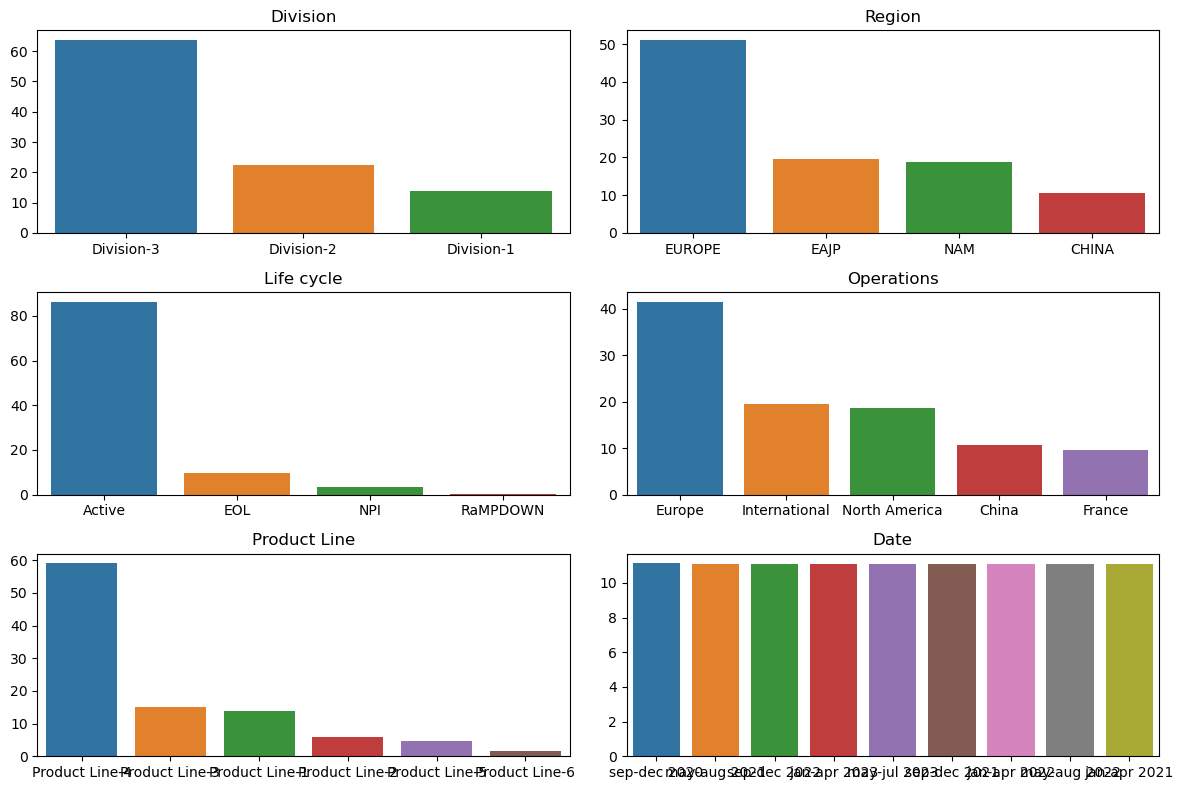

In [72]:
import seaborn as sns
# Select categorical variables with small number unique values
df_barplot = data[["Division","Region","Life cycle","Operations","Product Line","Date"]]

# Create barplot with frequency for each variable
plt.figure(figsize=(12,8))

for c,var in enumerate(df_barplot.columns):
  # compute frequency of each unique value
  df = df_barplot[var].value_counts(normalize=True).to_frame("frequency").reset_index(names=var)
  df["frequency"] = df["frequency"]*100

  # plot the barplot
  plt.subplot(3,2,c+1)
  sns.barplot(data=df, x=var, y="frequency")
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

In [73]:
# Select continuous variables
continuous_var = data.drop(columns=categorical_var).columns.to_list()

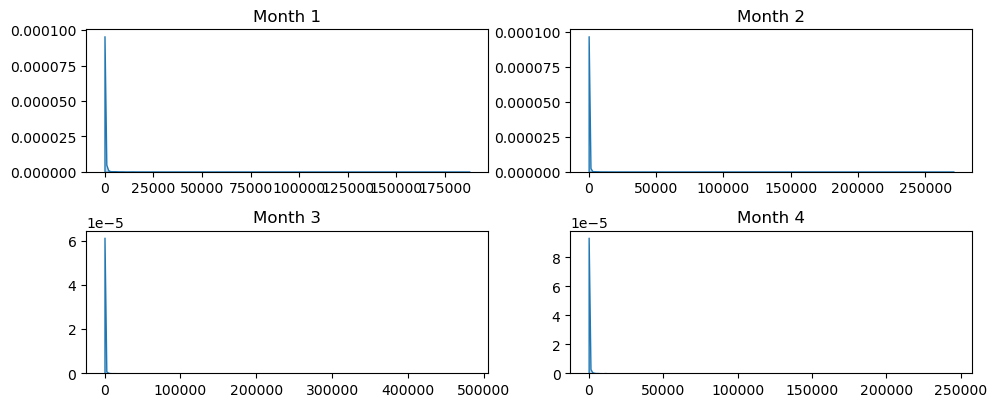

In [74]:
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=data[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

The volume of sales is really concentrated around 0, thus we will have to deal with all the outliers. First idea  could be maybe to remove all rows with a sales volume not in a 99% quantile.

<Axes: >

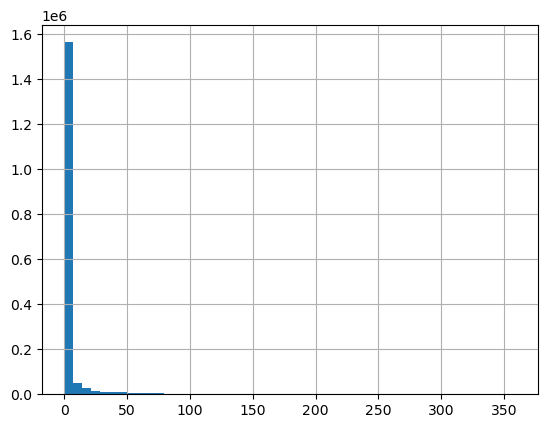

In [75]:
q2 = data["Month 2"].quantile(0.99)
(data[data["Month 2"]<q2]["Month 2"]).hist(bins=50)

# Data Pre-Processing